## Foreword

Home buyers and home sellers want tomake sure they are getting a fair price for a home they want to sell/purchase. It's difficult to set a fair price/target price without individually assessing a large amount of market data. This process would be easier if a model could be developed that would estimate the price of a buyer/seller's home to make it easier for them to reach a fair price. This could benefit buyers and sellers equally and ensure that one side isn't getting a significant price advantage.

A linear model will be developed to attempt to predict the prices of previously sold homes. The model will be evaluated using r2 score and neg mean squared error.

## Baseline Score

The baseline score for this model, in root mean squared error is about 80,000 which is just the average used as the prediction. By the end of this project, the root mean squared error is decreased to about 30,000. Since we are aiming for a lower score, this is a significant improvement.

## Libraries

In [7534]:
import pandas as pd

import seaborn as sns

import numpy as np

from scipy.stats import zscore

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt

## Functions

In [7535]:
#Checks if columns have the same variables

def variable_match(dataframe_1, dataframe_2):
    unique_1 = dataframe_1.unique()
    unique_2 = dataframe_2.unique()
    unique_1.sort()
    unique_2.sort()
    if list(unique_1) in list(unique_2):
        print('Match')
    else:
        print('No match')

In [7536]:
def d_types(column):
    print(train[f'{column}'].dtypes)
    print(test[f'{column}'].dtypes)

## Reading in Data

In [7537]:
train = pd.read_csv('datasets/train.csv')

In [7538]:
test = pd.read_csv('datasets/test.csv')

In [7539]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [7540]:
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


## Cleaning

#### NA Location

In [7541]:
#returns all columns that have NAs:
NA_columns = []
for column in train.columns:
    if train[column].isnull().sum() > 0:
        NA_columns.append(column)

In [7542]:
#calculates the percentage of values that are missing
#adds to dictionary
percent_NA = {}

for column in NA_columns:
    percent_NA[column] = train[column].isnull().sum() / len(train[column]) * 100

pd.DataFrame.from_dict(percent_NA, orient = 'index')

,0
Lot Frontage,16.089712
Alley,93.174061
Mas Vnr Type,1.072647
Mas Vnr Area,1.072647
Bsmt Qual,2.681619
Bsmt Cond,2.681619
Bsmt Exposure,2.827889
BsmtFin Type 1,2.681619
BsmtFin SF 1,0.048757
BsmtFin Type 2,2.730375


## Lot Frontage

In [7543]:
train['Lot Frontage'] = train['Lot Frontage'].fillna(train['Lot Frontage'].mean())

In [7544]:
test['Lot Frontage'] = test['Lot Frontage'].fillna(test['Lot Frontage'].mean())

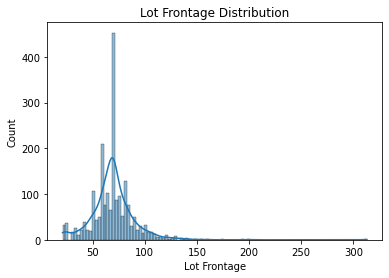

In [7545]:
sns.histplot(train['Lot Frontage'], kde = True);
plt.title('Lot Frontage Distribution');

There is a lot of skew in this distribution, so removing outliers may be necessary.

In [7546]:
d_types('Lot Frontage')

float64
float64


## Alley

In [7547]:
train['Mas Vnr Type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

In [7548]:
train['Alley'] = train['Alley'].fillna('NA')

In [7549]:
test['Alley'] = train['Alley'].fillna('NA')

In [7550]:
variable_match(train['Alley'], test['Alley'])

No match


In [7551]:
d_types('Alley')

object
object


## Mas Vnr Type

In [7552]:
train['Mas Vnr Type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

In [7553]:
train['Mas Vnr Type'] = train['Mas Vnr Type'].fillna('None')

In [7554]:
test['Mas Vnr Type'] = test['Mas Vnr Type'].fillna('None')

In [7555]:
variable_match(train['Mas Vnr Type'], test['Mas Vnr Type'])

No match


The variables in this column don't match for the train and test set, so I'm not going to use this is a feature.

In [7556]:
d_types('Mas Vnr Type')

object
object


## Mass Vnr Area

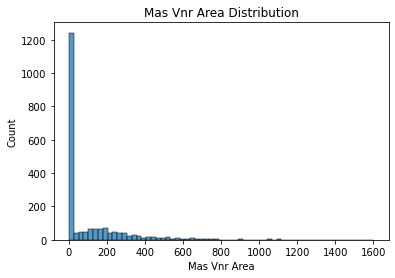

In [7557]:
sns.histplot(train['Mas Vnr Area'])
plt.title('Mas Vnr Area Distribution');

In [7558]:
#This is a very poasitively skewed distribution

(train['Mas Vnr Area']).skew()

2.5949168305314014

In [7559]:
train['Mas Vnr Area'].fillna(train['Mas Vnr Area'].mean()).skew()

2.608926245208541

In [7560]:
train['Mas Vnr Area'] = train['Mas Vnr Area'].fillna(train['Mas Vnr Area'].mean())

In [7561]:
test['Mas Vnr Area'] = test['Mas Vnr Area'].fillna(test['Mas Vnr Area'].mean())

In [7562]:
d_types('Mas Vnr Area')

float64
float64


## Bsmt Qual

In [7563]:
train['Bsmt Qual'].unique()

array(['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'], dtype=object)

In [7564]:
train['Bsmt Qual'] = train['Bsmt Qual'].fillna('NA')

In [7565]:
test['Bsmt Qual'] = test['Bsmt Qual'].fillna('NA')

In [7566]:
variable_match(train['Bsmt Qual'], test['Bsmt Qual'])

No match


In [7567]:
d_types('Bsmt Qual')

object
object


## Bsmt Cond

In [7568]:
train['Bsmt Cond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'], dtype=object)

In [7569]:
train['Bsmt Cond'] = train['Bsmt Cond'].fillna('NA')

In [7570]:
test['Bsmt Cond'] = test['Bsmt Cond'].fillna('NA')

In [7571]:
variable_match(train['Bsmt Cond'], test['Bsmt Cond'])

No match


In [7572]:
test['Bsmt Cond'].unique()

array(['TA', 'Gd', 'NA', 'Fa'], dtype=object)

Since this variable is ordinal, and the trains et contains all the variables of the test set, I will keep this variable.

In [7573]:
d_types('Bsmt Cond')

object
object


## Bsmt Exposure 	

In [7574]:
train['Bsmt Exposure'].unique()

array(['No', 'Gd', 'Av', nan, 'Mn'], dtype=object)

In [7575]:
train['Bsmt Exposure'] = train['Bsmt Exposure'].fillna('NA')

In [7576]:
test['Bsmt Exposure'] = test['Bsmt Exposure'].fillna('NA')

In [7577]:
variable_match(train['Bsmt Exposure'], test['Bsmt Exposure'])

No match


In [7578]:
d_types('Bsmt Exposure')

object
object


## BsmtFin Type 1

In [7579]:
train['BsmtFin Type 1'].unique()

array(['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'], dtype=object)

In [7580]:
train['BsmtFin Type 1'] = train['BsmtFin Type 1'].fillna('NA')

In [7581]:
test['BsmtFin Type 1'] = test['BsmtFin Type 1'].fillna('NA')

In [7582]:
variable_match(train['BsmtFin Type 1'], test['Bsmt Exposure'])

No match


In [7583]:
d_types('BsmtFin Type 1')

object
object


## BsmtFin SF 1

Text(0.5, 1.0, 'BsmtFin SF 1 Distribution')

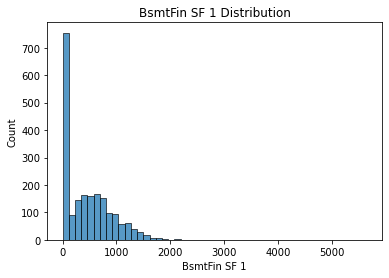

In [7584]:
sns.histplot(train['BsmtFin SF 1'])
plt.title('BsmtFin SF 1 Distribution')

In [7585]:
#This is a strong positive skew

train['BsmtFin SF 1'].skew()

1.6030901753777977

In [7586]:
#Filling does not create a significant distribution change

train['BsmtFin SF 1'].fillna(0).skew()

1.603375539421063

Skew is pretty much the same so this fill is okay.

In [7587]:
train['BsmtFin SF 1'] = train['BsmtFin SF 1'].fillna(0)

In [7588]:
test['BsmtFin SF 1'] = test['BsmtFin SF 1'].fillna(0)

In [7589]:
d_types('BsmtFin SF 1')

float64
int64


In [7590]:
test['BsmtFin SF 1'] = test['BsmtFin SF 1'].astype(float)

## BsmtFin Type 2

In [7591]:
train['BsmtFin Type 2'].unique()

array(['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'], dtype=object)

In [7592]:
train['BsmtFin Type 2'] = train['BsmtFin Type 2'].fillna('NA')

In [7593]:
test['BsmtFin Type 2'] = test['BsmtFin Type 2'].fillna('NA')

In [7594]:
variable_match(train['BsmtFin Type 2'], test['BsmtFin Type 2'])

No match


In [7595]:
d_types('BsmtFin Type 2')

object
object


## BsmtFin SF 2

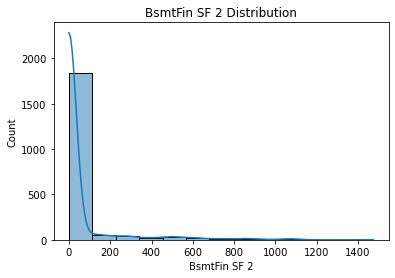

In [7596]:
sns.histplot(train['BsmtFin SF 2'], kde = True)
plt.title('BsmtFin SF 2 Distribution');

In [7597]:
train['BsmtFin SF 2'].skew()

4.239955039313746

In [7598]:
train['BsmtFin SF 2'].fillna(0).skew()

4.24113904311804

In [7599]:
train['BsmtFin SF 2'] = train['BsmtFin SF 2'].fillna(0)

In [7600]:
test['BsmtFin SF 2'] = test['BsmtFin SF 2'].fillna(0)

In [7601]:
d_types('BsmtFin SF 2')

float64
int64


In [7602]:
test['BsmtFin SF 2'] = test['BsmtFin SF 2'].astype(float)

## Bsmt Unf SF

Text(0.5, 1.0, 'Bsmt Unf SF Distribution')

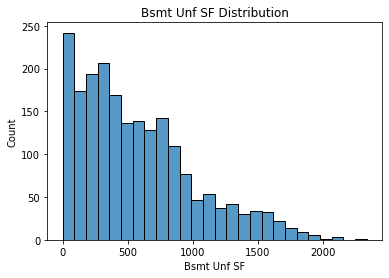

In [7603]:
sns.histplot(train['Bsmt Unf SF'])
plt.title('Bsmt Unf SF Distribution')

In [7604]:
train['Bsmt Unf SF'].skew()

0.908479916403976

In [7605]:
train['Bsmt Unf SF'].fillna(train['Bsmt Unf SF'].mean()).skew()

0.9087011453017043

In [7606]:
train['Bsmt Unf SF'] = train['Bsmt Unf SF'].fillna(train['Bsmt Unf SF'].mean())

In [7607]:
train['Bsmt Unf SF'] = train['Bsmt Unf SF'].fillna(train['Bsmt Unf SF'].mean())

In [7608]:
d_types('Bsmt Unf SF')

float64
int64


In [7609]:
test['Bsmt Unf SF'] = test['Bsmt Unf SF'].astype(float)

## Total Bsmt SF

Text(0.5, 1.0, 'Total Bsmt SF Distribution')

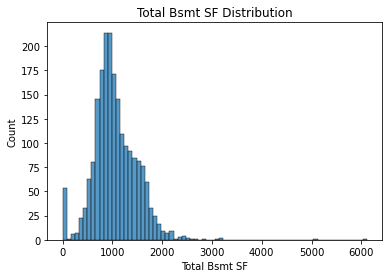

In [7610]:
sns.histplot(train['Total Bsmt SF'])
plt.title('Total Bsmt SF Distribution')

In [7611]:
train['Total Bsmt SF'].skew()

1.388912666293062

In [7612]:
train['Total Bsmt SF'].fillna(train['Total Bsmt SF'].mean()).skew()

1.3892508879891685

In [7613]:
train['Total Bsmt SF'] = train['Total Bsmt SF'].fillna(train['Total Bsmt SF'].mean())

In [7614]:
test['Total Bsmt SF'] = test['Total Bsmt SF'].fillna(test['Total Bsmt SF'].mean())

In [7615]:
d_types('Total Bsmt SF')

float64
int64


In [7616]:
test['Total Bsmt SF'] = test['Total Bsmt SF'].astype(float)

## Bsmt Full Bath

Text(0.5, 1.0, 'Bsmt Full Bath Distribution')

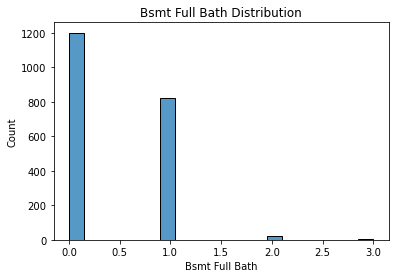

In [7617]:
sns.histplot(train['Bsmt Full Bath'])
plt.title('Bsmt Full Bath Distribution')

In [7618]:
#There are not that many 2 and 3 baths so I'm changing it to 0 or 1
train['Bsmt Full Bath'] = train['Bsmt Full Bath'].replace([1, 2,3], 1)

In [7619]:
train['Bsmt Full Bath'] = train['Bsmt Full Bath'].fillna(0)

In [7620]:
test['Bsmt Full Bath'] = test['Bsmt Full Bath'].replace([1, 2], 1)

In [7621]:
d_types('Bsmt Full Bath')

float64
int64


In [7622]:
test['Bsmt Full Bath'] = test['Bsmt Full Bath'].astype(float)

## Bsmt Half Bath

In [7623]:
train['Bsmt Half Bath'].unique()

array([ 0.,  1., nan,  2.])

In [7624]:
train['Bsmt Half Bath'].value_counts()

0.0    1923
1.0     122
2.0       4
Name: Bsmt Half Bath, dtype: int64

In [7625]:
train['Bsmt Half Bath'] = train['Bsmt Half Bath'].replace([1, 2], 1)

In [7626]:
train['Bsmt Half Bath'] = train['Bsmt Half Bath'].fillna(0)

In [7627]:
test['Bsmt Half Bath'] = test['Bsmt Half Bath'].replace([1, 2], 1)

In [7628]:
test['Bsmt Half Bath'].unique()

array([0, 1], dtype=int64)

In [7629]:
d_types('Bsmt Half Bath')

float64
int64


## Fireplace Qu

In [7630]:
train['Fireplace Qu'].unique()

array([nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'], dtype=object)

In [7631]:
train['Fireplace Qu'] = train['Fireplace Qu'].fillna('NA')

In [7632]:
test['Fireplace Qu'] = test['Fireplace Qu'].fillna('NA')

In [7633]:
variable_match(train['Fireplace Qu'], test['Fireplace Qu'])

No match


In [7634]:
d_types('Fireplace Qu')

object
object


## Garage Type

In [7635]:
train['Garage Type'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'Basment', nan, '2Types', 'CarPort'],
      dtype=object)

In [7636]:
train['Garage Type'] = train['Garage Type'].fillna('NA')

In [7637]:
test['Garage Type'] = test['Garage Type'].fillna('NA')

In [7638]:
variable_match(train['Garage Type'], test['Garage Type'])

No match


In [7639]:
d_types('Garage Type')

object
object


## Garage Yr Blt

In [7640]:
train[train['Garage Yr Blt'] > 2010]['Garage Yr Blt']

1699    2207.0
Name: Garage Yr Blt, dtype: float64

In [7641]:
train = train[train['Garage Yr Blt'] != 2207]

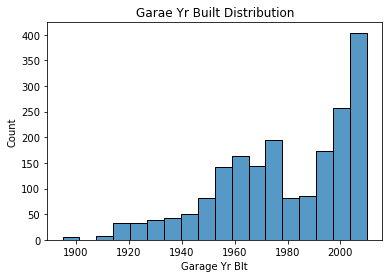

In [7642]:
sns.histplot(train['Garage Yr Blt'])
plt.title('Garae Yr Built Distribution');

In [7643]:
train['Garage Yr Blt'].value_counts()

2005.0    105
2007.0     84
2006.0     80
2004.0     72
2003.0     66
         ... 
1896.0      1
1919.0      1
1917.0      1
1895.0      1
1933.0      1
Name: Garage Yr Blt, Length: 99, dtype: int64

In [7644]:
# I won't use this column because there are a lot of value missing and I don't know how to fill them in

In [7645]:
train['Garage Yr Blt'].max()

2010.0

## Garage Finish

In [7646]:
train['Garage Finish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [7647]:
train['Garage Finish'] = train['Garage Finish'].fillna('NA')

In [7648]:
test['Garage Finish'] = test['Garage Finish'].fillna('NA')

In [7649]:
variable_match(train['Garage Finish'], test['Garage Finish'])

No match


In [7650]:
d_types('Garage Finish')

object
object


## Garage Cars

In [7651]:
train['Garage Cars'].unique()

array([ 2.,  1.,  3.,  0.,  4.,  5., nan])

Text(0.5, 1.0, 'Garage Cars Distribution')

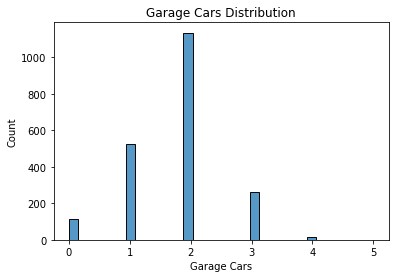

In [7652]:
sns.histplot(train['Garage Cars'])
plt.title('Garage Cars Distribution')

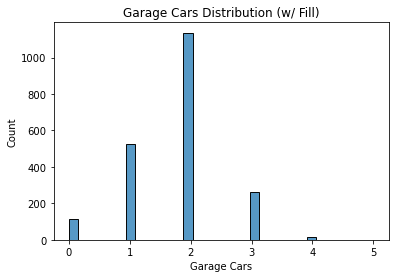

In [7653]:
sns.histplot(train['Garage Cars'].fillna(2))
plt.title('Garage Cars Distribution (w/ Fill)');

In [7654]:
train['Garage Cars'] = train['Garage Cars'].fillna(2)

In [7655]:
test['Garage Cars'].isnull().sum()

0

In [7656]:
train['Garage Cars'] = train['Garage Cars'].replace([0, 1], 0)

In [7657]:
#Change all cars 2+ to 1 and all below to 0
train['Garage Cars'] = train['Garage Cars'].replace([2, 3, 4, 5], 1)

In [7658]:
train['Garage Cars'].unique()

array([1., 0.])

In [7659]:
test['Garage Cars'] = test['Garage Cars'].replace([0, 1], 0)

In [7660]:
test['Garage Cars'] = test['Garage Cars'].replace([2, 3, 4], 1)

In [7661]:
test['Garage Cars'].unique()

array([0, 1], dtype=int64)

In [7662]:
d_types('Garage Cars')

float64
int64


## Garage Area

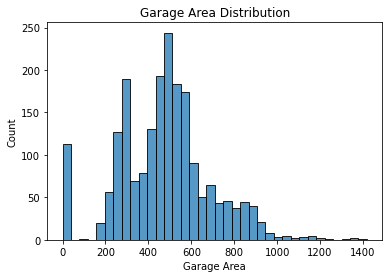

In [7663]:
sns.histplot(train['Garage Area'])
plt.title('Garage Area Distribution');

In [7664]:
#Pretty normal!
train['Garage Area'].skew()

0.1993864504215629

In [7665]:
train['Garage Area'].fillna(train['Garage Area'].mean()).skew()

0.1994350277617911

In [7666]:
train['Garage Area'] = train['Garage Area'].fillna(train['Garage Area'].mean())

In [7667]:
test['Garage Area'].isnull().sum()

0

In [7668]:
d_types('Garage Area')

float64
int64


## Garage Qual

In [7669]:
train['Garage Qual'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'], dtype=object)

In [7670]:
train['Garage Qual'] = train['Garage Qual'].fillna('NA')

In [7671]:
test['Garage Qual'] = test['Garage Qual'].fillna('NA')

In [7672]:
variable_match(train['Garage Qual'], test['Garage Qual'])

No match


In [7673]:
d_types('Garage Qual')

object
object


## Garage Cond

In [7674]:
train['Garage Cond'].unique()

array(['TA', 'Fa', nan, 'Po', 'Gd', 'Ex'], dtype=object)

In [7675]:
train['Garage Cond'] = train['Garage Cond'].fillna('NA')

In [7676]:
test['Garage Cond'] = test['Garage Cond'].fillna('NA')

In [7677]:
variable_match(train['Garage Cond'], test['Garage Cond'])

No match


In [7678]:
d_types('Garage Cond')

object
object


## Pool QC

In [7679]:
train['Pool QC'].unique()

array([nan, 'Fa', 'Gd', 'Ex', 'TA'], dtype=object)

In [7680]:
#Almost no information!
train['Pool QC'].value_counts()

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool QC, dtype: int64

In [7681]:
train['Pool QC'] = train['Pool QC'].fillna('NA')

In [7682]:
test['Pool QC'] = test['Pool QC'].fillna('NA')

In [7683]:
d_types('Pool QC')

object
object


## Fence

In [7684]:
train['Fence'].unique()

array([nan, 'MnPrv', 'GdPrv', 'GdWo', 'MnWw'], dtype=object)

In [7685]:
train['Fence'] = train['Fence'].fillna('NA')

In [7686]:
test['Fence'] = test['Fence'].fillna('NA')

In [7687]:
variable_match(train['Fence'], test['Fence'])

No match


In [7688]:
d_types('Fence')

object
object


## Misc Feature

In [7689]:
train['Misc Feature'].unique()

array([nan, 'Shed', 'TenC', 'Gar2', 'Othr', 'Elev'], dtype=object)

In [7690]:
train['Misc Feature'] = train['Misc Feature'].fillna('NA')

In [7691]:
test['Misc Feature'] = test['Misc Feature'].fillna('NA')

In [7692]:
test['Misc Feature'].unique()

array(['NA', 'Shed', 'Othr', 'Gar2'], dtype=object)

In [7693]:
variable_match(train['Misc Feature'], test['Misc Feature'])

No match


In [7694]:
d_types('Misc Feature')

object
object


## Electrical (in test set)

In [7695]:
test['Electrical'].unique()

array(['FuseP', 'SBrkr', 'FuseA', 'FuseF', nan], dtype=object)

In [7696]:
test['Electrical'].isnull().sum()

1

In [7697]:
test['Electrical'].value_counts()

SBrkr    813
FuseA     48
FuseF     15
FuseP      1
Name: Electrical, dtype: int64

In [7698]:
test['Electrical'] = test['Electrical'].fillna('SBrkr')

In [7699]:
test['Electrical'].value_counts()

SBrkr    814
FuseA     48
FuseF     15
FuseP      1
Name: Electrical, dtype: int64

In [7700]:
d_types('Electrical')

object
object


In [7701]:
#Change MS SubClass to object since it is not continuous

In [7702]:
train['MS SubClass'] = train['MS SubClass'].astype('object')

In [7703]:
test['MS SubClass'] = test['MS SubClass'].astype('object')

In [7704]:
#Change years to ages where possible
age = []
for year in train['Year Built']:
    age.append(train['Year Built'].max() - year)

In [7705]:
train['Year Built'] = age

In [7706]:
train.rename(columns = {'Year Built' : 'property_age'}, inplace = True)

In [7707]:
#Yr Sold
age = [train['Yr Sold'].max() - year for year in train['Yr Sold']]

In [7708]:
train['Yr Sold'] = age

In [7709]:
#Year Remod/Add
age = [train['Year Remod/Add'].max() - year for year in train['Year Remod/Add']]

In [7710]:
train['Year Remod/Add'] = age

In [7711]:
#Doing the same for the test set

In [7712]:
age = []
for year in test['Year Built']:
    age.append(test['Year Built'].max() - year)

In [7713]:
test['Year Built'] = age

In [7714]:
test.rename(columns = {'Year Built' : 'property_age'}, inplace = True)

In [7715]:
age = [test['Yr Sold'].max() - year for year in test['Yr Sold']]

In [7716]:
test['Yr Sold'] = age

In [7717]:
#Year Remod/Add
age = [test['Year Remod/Add'].max() - year for year in test['Year Remod/Add']]

In [7718]:
test['Year Remod/Add'] = age

## Column Drops

In [7719]:
# Don't need ID or PID columns for the train set. I also chose not to include
#the Garage Yr Built because I didn't want to incorrectly fill in missing values.
train.drop(columns = ['Garage Yr Blt', 'Id', 'PID'], inplace = True)

In [7720]:
test.drop(columns = 'Garage Yr Blt', inplace = True)

## Outliers

In [7721]:
#Let's look at the summary statistics for SalePrice

train['SalePrice'].describe()

#The distance from the min and mean and max and mean are very different which suggests there may be outliers.

count      2050.000000
mean     181427.833171
std       79255.308013
min       12789.000000
25%      129812.500000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

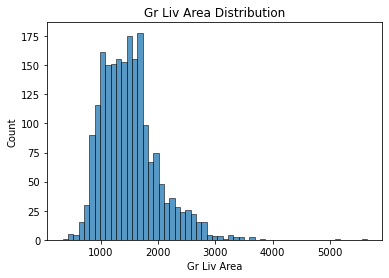

In [7722]:
#Removing outliers from Gr Liv Area because it is recommended in the data dictionary
sns.histplot(train['Gr Liv Area'])
plt.title('Gr Liv Area Distribution');

In [7723]:
train = train[train['Gr Liv Area'] < 4000]

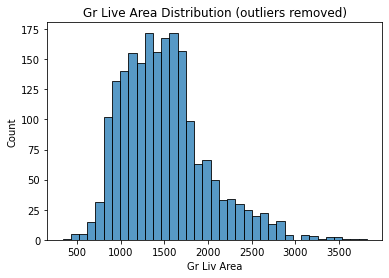

In [7724]:
sns.histplot(train['Gr Liv Area'])
plt.title('Gr Live Area Distribution (outliers removed)');

## Log transformation on SalePrice

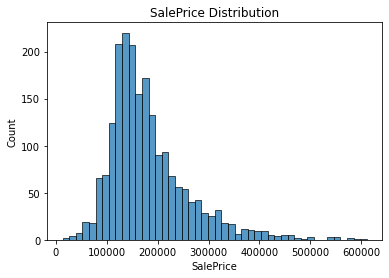

In [7725]:
#here the distribution is skewed to the right
sns.histplot(train['SalePrice'])
plt.title('SalePrice Distribution');

In [7726]:
train['SalePrice'].skew()

1.5584588270423345

Text(0.5, 1.0, 'SalePrice (log transformation)')

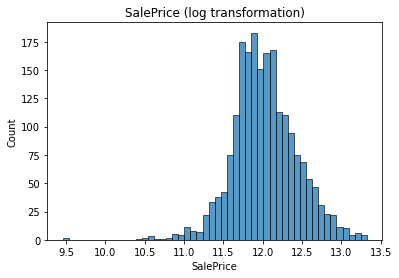

In [7727]:
#After log transformation, there is almost no skew, removing the lone 9.5 may decrease it even more.
sns.histplot(np.log(train['SalePrice']))
plt.title('SalePrice (log transformation)')

In [7728]:
np.log(train['SalePrice']).skew()

-0.14571926138003885

In [7729]:
log_SalePrice = np.log(train['SalePrice'])

In [7730]:
train['log_SalePrice'] = log_SalePrice

In [7731]:
#I'm going to remove 2 entries to make the log_SalePrice more normal
train = train[train['log_SalePrice'] > 9.5]

In [7732]:
train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,log_SalePrice
0,60,RL,69.0552,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,NA,NA,NA,0,3,0,WD,130500,11.779129
1,60,RL,43.0000,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,NA,NA,NA,0,4,1,WD,220000,12.301383
2,20,RL,68.0000,7922,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,1,0,WD,109000,11.599103
3,60,RL,73.0000,9802,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,4,0,WD,174000,12.066811
4,50,RL,82.0000,14235,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,3,0,WD,138500,11.838626


Now that all the features have been cleaned, it will be easier to create a model that may more accurately predict home prices.

## NA Final Check

In [7733]:
#train
NA_columns = []
for column in train.columns:
    if train[column].isnull().sum() > 0:
        NA_columns.append(column)
NA_columns

[]

In [7734]:
#test
NA_columns = []
for column in test.columns:
    if test[column].isnull().sum() > 0:
        NA_columns.append(column)
NA_columns

[]

## to_csv

In [7735]:
train.to_csv('train_cleaned.csv')

In [7736]:
test.to_csv('test_cleaned.csv')

## working dataframes

In [7737]:
train_clean = train.copy()

## Numerical Columns Only

In [7738]:
numeric_variables = train_clean.select_dtypes(exclude = 'object')

## Categorical Columns Only

In [7739]:
categorical_variables = train_clean.select_dtypes(include = 'object')

In [7740]:
categorical_variabels.head()

,MS SubClass,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type
0,60,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,...,NA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD
1,60,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,...,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD
2,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,NA,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD
3,60,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,...,NA,BuiltIn,Fin,TA,TA,Y,NA,NA,NA,WD
4,50,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,...,NA,Detchd,Unf,TA,TA,N,NA,NA,NA,WD


## Line Assumptions

### Linearity

I've chosen to keep all variables that have an absolute value correlation with the target variable of greater than 0.2

In [7741]:
corr_table = numeric_variables.corr()[['SalePrice']]

In [7742]:
corr_table

,SalePrice
Lot Frontage,0.340421
Lot Area,0.305343
Overall Qual,0.802548
Overall Cond,-0.101227
property_age,-0.571479
Year Remod/Add,-0.549916
Mas Vnr Area,0.516553
BsmtFin SF 1,0.445199
BsmtFin SF 2,0.015989
Bsmt Unf SF,0.189206


In [7743]:
linear_features = corr_table[corr_table['SalePrice'].abs() > 0.2].index

In [7744]:
numeric_variables = numeric_variables[linear_features]

In [7745]:
numeric_variables.head()

,Lot Frontage,Lot Area,Overall Qual,property_age,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,2nd Flr SF,...,Full Bath,Half Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,SalePrice,log_SalePrice
0,69.0552,13517,6,34,5,289.0,533.0,725.0,725,754,...,2,1,6,0,1.0,475.0,0,44,130500,11.779129
1,43.0000,11492,7,14,13,132.0,637.0,913.0,913,1209,...,2,1,8,1,1.0,559.0,0,74,220000,12.301383
2,68.0000,7922,5,57,3,0.0,731.0,1057.0,1057,0,...,1,0,5,0,0.0,246.0,0,52,109000,11.599103
3,73.0000,9802,5,4,3,0.0,0.0,384.0,744,700,...,2,1,7,0,1.0,400.0,100,0,174000,12.066811
4,82.0000,14235,6,110,17,0.0,0.0,676.0,831,614,...,2,0,6,0,1.0,484.0,0,59,138500,11.838626


Based on everything I have done so far, I believe I will be able to create a model that will assist home owners and home sellers in the valuation of their properties.

## Independence

The samples are independent.

## Creating variable for Linear Regression

In [7746]:
lr = LinearRegression()

## Multicollinearity

In [7747]:
#I will be checking for multicollinearity using variance inflation factor from stats
X = numeric_variables.iloc[ : , 0 : -2]

In [7748]:
#using the log of SalePrice column because it gets better r2s 

y = numeric_variables['log_SalePrice']

In [7749]:
#code sourced from: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
vif_data = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 

In [7750]:
vif_data = pd.DataFrame(vif_data, index = X.columns)

In [7751]:
vif_data = vif_data.sort_values(0, ascending = False)

In [7752]:
vif_data

,0
Gr Liv Area,1004.964450
1st Flr SF,634.739239
2nd Flr SF,119.879095
TotRms AbvGrd,54.223319
Overall Qual,32.536891
Total Bsmt SF,24.124233
Full Bath,21.973713
Garage Area,16.713953
Lot Frontage,16.032595
Garage Cars,8.320600


In [7753]:
#This is going to drop features with the highest VIF until there are only 10 features left
#The neg_mean_absolute_error and r2 score will be stored as the keys in dictionaries with the features
#that led to the score as the value.

models_r2 = {}
models_nmse = {}

while len(vif_data) > 10:
    vif_data = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif_data = pd.DataFrame(vif_data, index = X.columns)
    score = cross_val_score(lr, X, y, cv = 20).mean()
    models_r2[score] = vif_data.index
    score = cross_val_score(lr, X, y, scoring = 'neg_mean_absolute_error', cv = 20).mean()
    models_nmse[score] = vif_data.index
    vif_data = vif_data.sort_values(0, ascending = False)
    vif_data = vif_data.iloc[1 : , :]
    features = vif_data.index
    X = X[features]

In [7754]:
models_r2

{0.8895168573805055: Index(['Lot Frontage', 'Lot Area', 'Overall Qual', 'property_age',
        'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
        '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',
        'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars',
        'Garage Area', 'Wood Deck SF', 'Open Porch SF'],
       dtype='object'),
 0.8894048844713167: Index(['1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Overall Qual',
        'Total Bsmt SF', 'Full Bath', 'Garage Area', 'Lot Frontage',
        'Garage Cars', 'property_age', 'Year Remod/Add', 'BsmtFin SF 1',
        'Lot Area', 'Half Bath', 'Bsmt Full Bath', 'Fireplaces', 'Mas Vnr Area',
        'Open Porch SF', 'Wood Deck SF'],
       dtype='object'),
 0.8790353592141246: Index(['TotRms AbvGrd', 'Overall Qual', 'Total Bsmt SF', 'Full Bath',
        'Garage Area', 'Lot Frontage', 'Garage Cars', '2nd Flr SF',
        'property_age', 'Year Remod/Add', 'BsmtFin SF 1', 'Lot Area',


In [7755]:
models_nmse

{-0.0949164636504695: Index(['Lot Frontage', 'Lot Area', 'Overall Qual', 'property_age',
        'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
        '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',
        'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars',
        'Garage Area', 'Wood Deck SF', 'Open Porch SF'],
       dtype='object'),
 -0.09496931293023869: Index(['1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Overall Qual',
        'Total Bsmt SF', 'Full Bath', 'Garage Area', 'Lot Frontage',
        'Garage Cars', 'property_age', 'Year Remod/Add', 'BsmtFin SF 1',
        'Lot Area', 'Half Bath', 'Bsmt Full Bath', 'Fireplaces', 'Mas Vnr Area',
        'Open Porch SF', 'Wood Deck SF'],
       dtype='object'),
 -0.09961161238328052: Index(['TotRms AbvGrd', 'Overall Qual', 'Total Bsmt SF', 'Full Bath',
        'Garage Area', 'Lot Frontage', 'Garage Cars', '2nd Flr SF',
        'property_age', 'Year Remod/Add', 'BsmtFin SF 1', 'Lot Ar

In [7756]:
# I chose to be fairly harsh on the VIF so the r2 score took a hit,
#but it still performs at 0.83 which isn't bad.

X = numeric_variables[['Total Bsmt SF', 'Garage Area',
        'Lot Frontage', 'Garage Cars', 'property_age', '2nd Flr SF',
        'Year Remod/Add', 'BsmtFin SF 1', 'Lot Area', 'Half Bath',
        'Bsmt Full Bath', 'Fireplaces', 'Mas Vnr Area', 'Wood Deck SF',
        'Open Porch SF']]

In [7757]:
#code sourced from: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
vif_data = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 

In [7758]:
vif_data = pd.DataFrame(vif_data, index = X.columns)

In [7759]:
vif_data = vif_data.sort_values(0, ascending = False)

In [7760]:
#I was able to get rid of a lot of multicollinearity without taking TOO big of a hit on r2 score

vif_data

,0
Garage Area,15.456143
Lot Frontage,12.886090
Total Bsmt SF,11.633265
Garage Cars,7.540733
property_age,5.104174
BsmtFin SF 1,4.328929
Year Remod/Add,4.314046
Lot Area,4.117430
2nd Flr SF,3.166040
Bsmt Full Bath,2.987100


## Linear Regression Test

In [7761]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [7762]:
#So this is pretty good performance for just numerical features, 
#especially considering we went from 30+ columns to only 16
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8312138281805539

In [7763]:
residuals = y_test - lr.predict(X_test) 

Text(0.5, 0, 'log_SalePrice Residual')

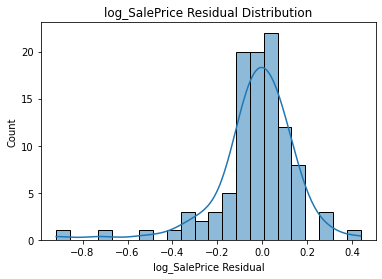

In [7764]:
sns.histplot(residuals, kde = True)
plt.title('log_SalePrice Residual Distribution')
plt.xlabel('log_SalePrice Residual')

In [7765]:
#Nice, that's pretty much normal

residuals.skew()

-1.795597448244649

C:\Users\Anonymous\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


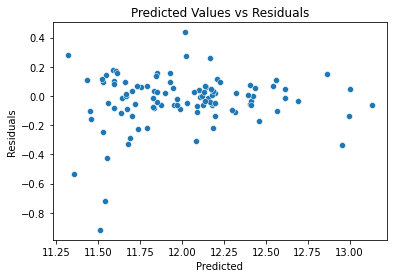

In [7766]:
#I would say this is pretty random. One could argue
#there is a pattern, but it seems mostly random
sns.scatterplot(lr.predict(X_test), residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted Values vs Residuals');

## Ridge regression

In [7767]:
#Code from https://www.youtube.com/watch?v=0yI0-r3Ly40&t=322s

ridge = Ridge()
parameters = {'alpha' : [1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring = 'r2', cv = 20)
ridge_regressor.fit(X, y)

GridSearchCV(cv=20, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='r2')

In [7768]:
#This score is an improvement on the initial linear regression

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 10}
0.8353070636892251


In [7769]:
ridge_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 20)
ridge_regressor.fit(X, y)

GridSearchCV(cv=20, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error')

In [7770]:
#This score is an improvement on the previous score

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 10}
-0.02665945328648527


In [7771]:
residuals_ridge = y_test - ridge_regressor.predict(X_test)

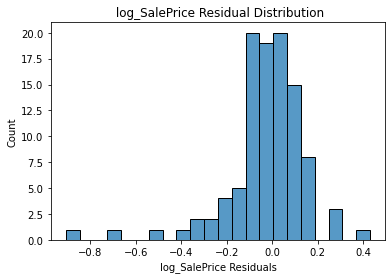

In [7772]:
sns.histplot(residuals_ridge)
plt.xlabel('log_SalePrice Residuals')
plt.title(' log_SalePrice Residual Distribution');

In [7773]:
#Nice! This is pretty normal since it's clsoe to 0.

residuals_ridge.skew()

-1.7972415494614473

C:\Users\Anonymous\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Residuals vs Predicted Values')

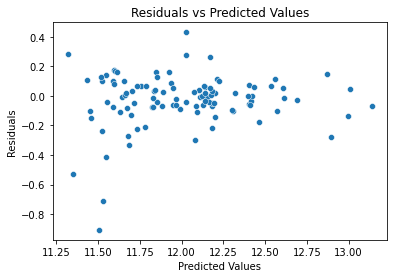

In [7774]:
#Looks pretty random to me.

sns.scatterplot(ridge_regressor.predict(X_test), residuals_ridge)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

## Lasso Regression

In [7775]:
lasso = Lasso()

In [7776]:
#Running GridSearch to helpfind the best parameters
#Using the same parameters as in the last GridSearch

lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'r2', cv = 20)
lasso_regressor.fit(X, y)

C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.087158500512196, tolerance: 0.031838186795103814
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.185884834141866, tolerance: 0.03152837967035225
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.530475501716694, tolerance: 0.032057983322464005
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

GridSearchCV(cv=20, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='r2')

In [7777]:
#This is also an improvement on the previous score

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.001}
0.8353297444203733


In [7778]:
lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_absolute_error', cv = 20)
lasso_regressor.fit(X, y)

C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.087158500512196, tolerance: 0.031838186795103814
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.185884834141866, tolerance: 0.03152837967035225
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.530475501716694, tolerance: 0.032057983322464005
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

GridSearchCV(cv=20, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_absolute_error')

In [7779]:
#The neg_mean_squared_error also improved

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.01}
-0.11607433707591719


Ridge regression created the most optimal model because it had the lowest neg mean squared error and highest r2 value. Its residuals were normally distributed and their variance on the scatterplot was random. Since I am aiming for the best r2 value and lowest neg mean squared error, the model that fits those criteria will be the model I choose. In this situation it was the ridge model.

We now have the best model using numerical features to predict fair market value for a home.

## Categorical Variable

## EDA

### Neighborhood

C:\Users\Anonymous\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


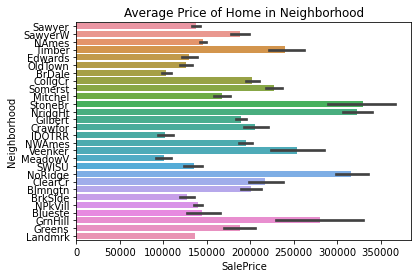

In [7780]:
sns.barplot(numeric_variables['SalePrice'], categorical_variables['Neighborhood'], orient = 'h');
plt.title('Average Price of Home in Neighborhood');

I can see that there are some neighborhoods with higher average prices for homes, so I'm going to divide them into two groups : greater than $150,000 and less than $150,000. This is really the only variable that should have significant impact on the price of a home, so I will add this one to the model.

## Pseudo One-Hot Encoding Neighborhood Column

In [7781]:
neighb_price = pd.DataFrame()

In [7782]:
neighb_price['Neighborhood'] = categorical_variables['Neighborhood']

In [7783]:
neighb_price['SalePrice'] = numeric_variables['SalePrice']

In [7784]:
neighb_avg = neighb_price.groupby('Neighborhood').mean()

In [7785]:
neighb_avg

,SalePrice
Neighborhood,
Blmngtn,200417.681818
Blueste,144566.666667
BrDale,103371.052632
BrkSide,127022.697368
ClearCr,217490.074074
CollgCr,202497.216667
Crawfor,205901.211268
Edwards,129905.787234
Gilbert,189228.387931


In [7786]:
neighb_avg['SalePrice'] = [1 if value > 150000 else 0 for value in neighb_avg['SalePrice']]

In [7787]:
neighb_avg = neighb_avg.to_dict()

In [7788]:
neighb_avg

{'SalePrice': {'Blmngtn': 1,
  'Blueste': 0,
  'BrDale': 0,
  'BrkSide': 0,
  'ClearCr': 1,
  'CollgCr': 1,
  'Crawfor': 1,
  'Edwards': 0,
  'Gilbert': 1,
  'Greens': 1,
  'GrnHill': 1,
  'IDOTRR': 0,
  'Landmrk': 0,
  'MeadowV': 0,
  'Mitchel': 1,
  'NAmes': 0,
  'NPkVill': 0,
  'NWAmes': 1,
  'NoRidge': 1,
  'NridgHt': 1,
  'OldTown': 0,
  'SWISU': 0,
  'Sawyer': 0,
  'SawyerW': 1,
  'Somerst': 1,
  'StoneBr': 1,
  'Timber': 1,
  'Veenker': 1}}

In [7789]:
#For train set

neighborhood_conversion = []

for i in categorical_variables['Neighborhood']:
    neighborhood_conversion.append(neighb_avg['SalePrice'][i])

In [7790]:
categorical_variables['Neighborhood'] = neighborhood_conversion

<ipython-input-7790-590131a3e30b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_variables['Neighborhood'] = neighborhood_conversion


In [7791]:
#For test set

neighborhood_conversion = []

for i in test['Neighborhood']:
    neighborhood_conversion.append(neighb_avg['SalePrice'][i])

In [7792]:
test['Neighborhood'] = neighborhood_conversion

In [7793]:
#Adding this to numeric variables

numeric_variables['Neighborhood'] = categorical_variables['Neighborhood']

In [7794]:
categorical_variables.drop(columns = 'Neighborhood', inplace = True)

C:\Users\Anonymous\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7795]:
numeric_variables

C:\Users\Anonymous\anaconda3\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,Lot Frontage,Lot Area,Overall Qual,property_age,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,2nd Flr SF,...,Half Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,SalePrice,log_SalePrice,Neighborhood
0,69.0552,13517,6,34,5,289.0,533.0,725.0,725,754,...,1,6,0,1.0,475.0,0,44,130500,11.779129,0
1,43.0000,11492,7,14,13,132.0,637.0,913.0,913,1209,...,1,8,1,1.0,559.0,0,74,220000,12.301383,1
2,68.0000,7922,5,57,3,0.0,731.0,1057.0,1057,0,...,0,5,0,0.0,246.0,0,52,109000,11.599103,0
3,73.0000,9802,5,4,3,0.0,0.0,384.0,744,700,...,1,7,0,1.0,400.0,100,0,174000,12.066811,1
4,82.0000,14235,6,110,17,0.0,0.0,676.0,831,614,...,0,6,0,1.0,484.0,0,59,138500,11.838626,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,79.0000,11449,8,3,3,0.0,1011.0,1884.0,1728,0,...,0,7,1,1.0,520.0,0,276,298751,12.607366,1
2047,69.0552,12342,4,70,60,0.0,262.0,861.0,861,0,...,0,4,0,1.0,539.0,158,0,82500,11.320554,0
2048,57.0000,7558,6,82,60,0.0,0.0,896.0,1172,741,...,1,9,1,1.0,342.0,0,0,177000,12.083905,1
2049,80.0000,10400,4,54,54,0.0,155.0,1200.0,1200,0,...,0,6,2,0.0,294.0,0,189,144000,11.877569,0


## Linear Model Retest with Dummied Variable

In [7796]:
X['Neighborhood'] = numeric_variables['Neighborhood']

<ipython-input-7796-66dce41e6a0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Neighborhood'] = numeric_variables['Neighborhood']


In [7797]:
cross_val_score(lr, X, y, cv = 20).mean()

0.8388831805975843

In [7798]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [7799]:
lr.fit(X_train, y_train)

LinearRegression()

In [7800]:
lr.score(X_test, y_test)

0.8315436426755272

In [7801]:
residuals = y_test - lr.predict(X_test)

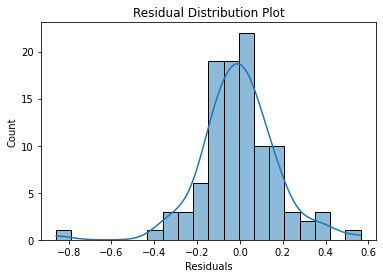

In [7802]:
sns.histplot(residuals, kde = True)
plt.title('Residual Distribution Plot')
plt.xlabel('Residuals');

In [7803]:
#Residuals are normally distributed.

residuals.skew()

-0.5585781378984385

C:\Users\Anonymous\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


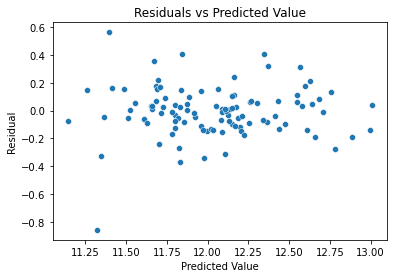

In [7804]:
#This is a random distribution so that fits the equal variance assumption. 

sns.scatterplot(lr.predict(X_test), residuals)
plt.title('Residuals vs Predicted Value')
plt.xlabel('Predicted Value')
plt.ylabel('Residual');

## Lasso Model With Dummied Variable

In [7805]:
lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'r2', cv = 20)
lasso_regressor.fit(X, y)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.550069827341897, tolerance: 0.031838186795103814
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.899217629880205, tolerance: 0.03152837967035225
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.789830764964357, tolerance: 0.032057983322464005
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

{'alpha': 1e-15}
0.8388831805975835


C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.819731910417516, tolerance: 0.0333510426955359
  model = cd_fast.enet_coordinate_descent(


In [7806]:
lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_absolute_error', cv = 20)
lasso_regressor.fit(X, y)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.550069827341897, tolerance: 0.031838186795103814
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.899217629880205, tolerance: 0.03152837967035225
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.789830764964357, tolerance: 0.032057983322464005
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anonymous\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

{'alpha': 1e-08}
-0.11534023295403624


Lasso didn't really give me results that I wanted so I won't be using this model.

## Ridge Model with Dummied Variables

In [7807]:
ridge_regressor = GridSearchCV(ridge, parameters, scoring = 'r2', cv = 20)
ridge_regressor.fit(X, y)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 5}
0.8388898703957384


In [7808]:
ridge_regressor = GridSearchCV(ridge, parameters, scoring = 'neg_mean_absolute_error', cv = 20)
ridge_regressor.fit(X, y)
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 100}
-0.1150146930632688


## Kaggle Submission

In [7809]:
predictions = lr.predict(test[X.columns])

In [7810]:
#Reversing the log to get regular prices
unlog_predictions = np.e ** predictions

In [7811]:
submission = pd.DataFrame()

In [7812]:
submission['Id'] = test['Id']

In [7813]:
submission['SalePrice'] = unlog_predictions

In [7814]:
submission.set_index('Id', inplace = True)

In [7815]:
submission.to_csv('submission_final.csv')

## Inference

In [7816]:
lr.coef_

array([ 3.11504603e-04,  3.16122349e-04,  1.37166995e-03, -1.30884938e-02,
       -1.91541620e-03,  2.38637028e-04, -3.73175515e-03,  7.60049649e-05,
        2.87442336e-06, -8.27619728e-03,  1.65521087e-02,  9.72771085e-02,
        1.13556646e-04,  8.22326555e-05,  1.55888664e-04,  7.37437278e-02])

In [7817]:
coefficients = pd.DataFrame()

In [7818]:
coefficients['variable'] = X.columns

In [7819]:
coefficients['coefficient'] = lr.coef_

In [7839]:
coefficients.sort_values('coefficient', ascending = False).head()

,variable,coefficient
11,Fireplaces,0.097277
15,Neighborhood,0.073744
10,Bsmt Full Bath,0.016552
2,Lot Frontage,0.001372
1,Garage Area,0.000316


From this table we can see that Fireplaces and Neighborhood have the largest effect on the price of a home in our model. This is because their coefficients are the largest.

## Conclusion and Recommendation

Conclusion: The best models were ridge and regular linear regression, but the differences in r2 and neg_mean_absolute_error are not very significant. A success of this model is that there is limited multicolinearity and good r2 score performance. An r2 score of 0.84 and neg mean squared error if -0.12 is good performance, it means the model can account for 84% of the variance of predictor variables. A downfall of this model is that it is difficult to deal with overfitting since etting rid of multicolinearity comes with the cost of sacrificing some r2 and neg mean squared error scores.

Something that could improve this project is a model that uses more advanced models such XGBoost and neural networks. These would likely be more accurate.

Recommendation: This model can be used to get an approximate value of a property and assisst in the pricing of a property.

## Visuals for presentation

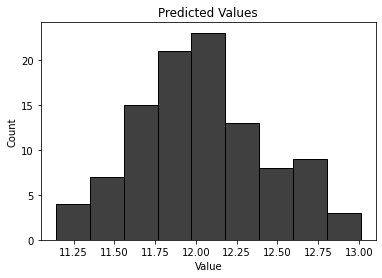

In [7846]:
sns.histplot(lr.predict(X_test), color = 'black')
plt.title('Predicted Values')
plt.xlabel('Value');
plt.savefig('predicted.jpg')

In [7829]:
actual = pd.DataFrame(y_test)

In [7843]:
actual = actual[actual['log_SalePrice'] >= 11.25]

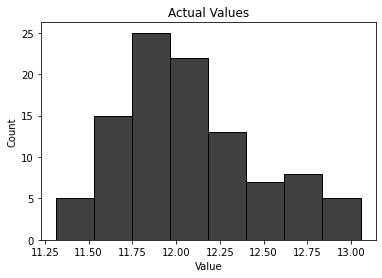

In [7847]:
sns.histplot(actual['log_SalePrice'], color = 'black')
plt.title('Actual Values')
plt.xlabel('Value');
plt.savefig('actual.jpg')